# Load Toy dataset

In [1]:
import scipy.io
import numpy as np
from numpy import linalg as LA
import time
import matplotlib.pyplot as plt
%matplotlib inline
mat = scipy.io.loadmat('okl/data/synthdata.mat')

In [39]:
import seaborn as sns

In [3]:
print('Shape of Ktrain:')
print(mat['Ktrain'].shape)
print('Shape of Kvalid:')
print(mat['Kvalid'].shape)
print('Shape of Ktest:')
print(mat['Ktest'].shape)

print('Shape of Ytrain:')
print(mat['Ytrain'].shape)
print('Shape of Yvalid:')
print(mat['Yvalid'].shape)
print('Shape of Ytest:')
print(mat['Y0'].shape)

Shape of Ktrain:
(100, 100)
Shape of Kvalid:
(100, 100)
Shape of Ktest:
(200, 100)
Shape of Ytrain:
(100, 200)
Shape of Yvalid:
(100, 200)
Shape of Ytest:
(200, 200)


# OKL

In [4]:
def okl(K,Y,lam_list):
    
    """
    OKL with block coordinate descent
    
    model = okl(K,Y,lam_list)
    -------------------------------------------   
    Inputs:
        K: input kernel matrix: (l x l) matrix,
        Y: training outputs: (l x m) matrix.
        lam_list: list of regularization parameters.
        
    --------------------------------------------
    Output:
        model : output model containing the following information:
        L : output kernel
        C : coefficient matrix
        lambda : regularization parameter
        J : value of the objective functional
        time : execution time          
    """

    #constants
    l = K.shape[0]
    m = Y.shape[1]
    N = len(lam_list)
    MAX_ITER = 1000
    TOL = 0.001
    delta = TOL * LA.norm(Y)

    # initialization 
    J = np.zeros((MAX_ITER,1))
    L = np.eye(m)
    C = np.zeros((l,m))

    # eigendecomposition of the input kernel matrix
    DX, UX = LA.eigh(K)
    '''
    For Symetric Real matrix :
    LA.eig -> complex space (due to computation issue)
    LA.eigh -> real space
    '''
    DX_ = DX.reshape((len(DX),1)) 
    dx = abs(DX_)
    '''
    The eigenvalues may be negative -> abs
    '''
    DX = np.diag(DX)
    Ytilde = np.dot(UX.T,Y)

    # MAIN loop
    model={}
    for k in range(N):
        start_time = time.time()
        lam = lam_list[k]
        print("lambda = "+str(lam))
        nit = 0
        res = LA.norm(Y)
    
        while(res > delta):
            # Sub-problem w.r.t. C.
            # Solve the Sylvester equation KCL+lambda*C = Y using eigendecomposition of K and L. 
            DY, UY = LA.eigh(L)
            DY_ = DY.reshape((len(DY),1))
            dy = abs(DY_)
            DY = np.diag(DY)
            Q = np.dot(Ytilde,UY)
            V = Q / (np.dot(dx,dy.T)+lam) #element wise division
            C = np.dot(np.dot(UX,V),UY.T)
        
            # Sub-problem w.r.t. L
            F = np.dot(V,UY.T)
            E = np.dot(DX,F)
            R = np.dot(E.T,E)
            DE, UE = LA.eigh(R)        
            DE_ = DE.reshape((len(DE),1))
            dep = abs(DE_)+lam
            DE = np.diag(DE)
        
            Lp = L
            temp = np.dot(R,L) + np.dot(L.T,R.T) + lam*np.dot(E.T,F)
            P = np.dot(np.dot(UE.T,temp),UE)
            temp = np.dot(dep,np.ones((1,m))) + np.dot(np.ones((m,1)),dep.T)
            L =np.dot(np.dot(UE, P/temp), UE.T)
        
            # Compute the value of the objective functional
            temp = F / 4 - Ytilde / (2*lam)
            J[nit] = LA.norm(Y)**2 / (2*lam) + np.trace(np.dot(np.dot(temp.T,E),L))
            #Compute the variation of L
            res = LA.norm(L-Lp)
        
            #Check whether the maximum number of iterations has been reached
            if nit >= MAX_ITER:
                print('Reached maximum number of iterations')
                break
            
            nit += 1
        modelk={}
        modelk['L']=L
        modelk['C']=C
        modelk['nit']=nit
        modelk['lambda']=lam
        modelk['J']=J[:nit]
        modelk['time']=time.time() - start_time
        model[k]=modelk
    return model

# Low rank OKL

In [5]:
def lrokl(K,Y,lam_list,p):
    
    """
    Low rank OKL with block coordinate descent
    
    model = lrokl(K,Y,lam_list,p)
    -------------------------------------------   
    Inputs:
        K: input kernel matrix: (l x l) matrix,
        Y: training outputs: (l x m) matrix.
        lam_list: list of regularization parameters.
        p : rank parameter
    --------------------------------------------
    Output:
        model : output model containing the following information:
        B : linear operators
        A : coefficient matrix
        lambda : regularization parameter
        J : value of the objective functional
        time : execution time          
    """

    #constants
    l = K.shape[0]
    m = Y.shape[1]
    N = len(lam_list)
    MAX_ITER = 1000
    TOL = 0.001
    delta = TOL * LA.norm(Y)

    # initialization 
    J = np.zeros((MAX_ITER,1))
    B = np.eye(m,p)

    # eigendecomposition of the input kernel matrix
    DX, UX = LA.eigh(K)
    '''
    For Symetric Real matrix :
    LA.eig -> complex space (due to computation issue)
    LA.eigh -> real space
    '''
    DX_ = DX.reshape((len(DX),1)) 
    dx = abs(DX_)
    '''
    The eigenvalues may be negative -> abs
    '''
    DX = np.diag(DX)
    Ytilde = np.dot(UX.T,Y)

    # MAIN loop
    model={}
    for k in range(N):
        start_time = time.time()
        lam = lam_list[k]
        #print("lambda = "+str(lam))
        nit = 0
        res = LA.norm(Y)
    
        while(res > delta):
        # Sub-problem w.r.t. A.
            # Solve the Sylvester equation KAB'B+lambda*A = YB 
            # via eigendecomposition of K and B'B
            DY, UY = LA.eigh(np.dot(B.T,B))
            DY_ = DY.reshape((len(DY),1))
            dy = abs(DY_)
            DY = np.diag(DY)
            Q = np.dot(np.dot(Ytilde,B),UY)
            V = Q / (np.dot(dx,dy.T)+lam) #element wise division
        
            # Sub-problem w.r.t. B
            Bp = B
            E = np.dot(DX,V)
            temp = LA.inv(np.dot(E.T,E)+lam*np.eye(p))
            P = np.dot(np.dot(Ytilde.T,E),temp) 
            B = np.dot(P,UY.T)

            # Compute the value of the objective functional
            if l > m:
                temp =np.dot((Ytilde - np.dot(E,P.T)).T,Ytilde)/lam
            else:
                temp =(np.dot(Ytilde,(Ytilde - np.dot(E,P.T)).T))/lam
            J[nit] = (np.trace(temp) + np.trace(np.dot(V.T,E)))/2
            
            # Compute the increment of B
            res = LA.norm(B-Bp)
        
            #Check whether the maximum number of iterations has been reached
            if nit >= MAX_ITER:
                print('Reached maximum number of iterations')
                break
            nit += 1
        A = np.dot(np.dot(UX,V),UY.T)
        modelk={}
        modelk['A']=A
        modelk['B']=B
        modelk['nit']=nit
        modelk['lambda']=lam
        modelk['J']=J[:nit]
        modelk['time']=time.time() - start_time
        model[k]=modelk
    return model

# Training

In [10]:
Ktrain = mat['Ktrain']
Ytrain = mat['Ytrain']
N = 30
lam_list = np.logspace(-5,0,N) * np.sqrt(LA.norm(np.dot(np.dot(Ytrain.T,Ktrain),Ytrain)))
lam_list = np.sort(lam_list)[::-1]

model = okl(Ktrain,Ytrain,lam_list)

model2 = {}
p_list = np.array(range(200))+1
for it,p in enumerate(p_list):
    print('p = '+str(p))  
    modelp = lrokl(Ktrain,Ytrain,lam_list,p)
    model2[it] = modelp

lambda = 1031.82831001
lambda = 693.735064446
lambda = 466.422887388
lambda = 313.592783511
lambda = 210.839640441
lambda = 141.755028555
lambda = 95.3069739575
lambda = 64.0782861638
lambda = 43.0821228205
lambda = 28.9656515154
lambda = 19.4746431416
lambda = 13.0934988736
lambda = 8.80322743312
lambda = 5.9187245508
lambda = 3.97937013151
lambda = 2.67547281642
lambda = 1.7988160324
lambda = 1.20940833282
lambda = 0.813128462917
lambda = 0.54669533793
lambda = 0.367562822044
lambda = 0.247125626972
lambda = 0.166151394657
lambda = 0.111709523147
lambda = 0.0751063064346
lambda = 0.0504966551406
lambda = 0.0339507066907
lambda = 0.0228262739699
lambda = 0.0153469201125
lambda = 0.0103182831001
p = 1
p = 2
p = 3
p = 4
p = 5
p = 6
p = 7
p = 8
p = 9
p = 10
p = 11
p = 12
p = 13
p = 14
p = 15
p = 16
p = 17
p = 18
p = 19
p = 20
p = 21
p = 22
p = 23
p = 24
p = 25
p = 26
p = 27
p = 28
p = 29
p = 30
p = 31
p = 32
p = 33
p = 34
p = 35
p = 36
p = 37
p = 38
p = 39
p = 40
p = 41
p = 42
p = 43
p =

# Test

In [11]:
Kvalid = mat['Kvalid']
Yvalid = mat['Yvalid']
Ktest = mat['Ktest']
Y0 = mat['Y0']
def mse(Y,Y_pred):
    return np.mean((Y-Y_pred)**2)

### Identity baseline

In [12]:
#Identity baseline
IDVMSE= np.zeros((N,1))
IDMSE = np.zeros((N,1))
DX,UX = LA.eigh(Ktrain)
DX_ = DX.reshape((len(DX),1))
dx = abs(DX_)
DX = np.diag(DX)
l = Ktrain.shape[0]
m = Ytrain.shape[1]
for k in range(N):
    lam = lam_list[k]
    temp =  np.dot(dx,np.ones((1,m))) + lam
    C = np.dot(UX, np.dot(UX.T,Ytrain) / temp)
    IDVMSE[k] = mse(Yvalid,np.dot(Kvalid,C))
    IDMSE[k] = mse(Y0,np.dot(Ktest,C))
ii = np.argmin(IDVMSE)

In [13]:
print('For baseline method, when lambda = %.3f,\nvalidation MSE reaches the minimum = %.3f' %(lam_list[ii],IDVMSE[ii]))

For baseline method, when lambda = 0.813,
validation MSE reaches the minimum = 19.953


### OKL

In [14]:
def predict(K,C,L):
    return np.dot(np.dot(K,C),L)
OKLVMSE= np.zeros((N,1))
OKLMSE = np.zeros((N,1))
ex_time = np.zeros((N,1))
for k in range(N):
    ex_time[k] = model[k]['time']
    OKLVMSE[k] = mse(Yvalid, predict(Kvalid,model[k]['C'],model[k]['L']))
    OKLMSE[k] =mse(Y0, predict(Ktest,model[k]['C'],model[k]['L']))
jj = np.argmin(OKLVMSE)

In [15]:
print('For OKL, when lambda = %.3f,\nvalidation MSE reaches the minimum = %.3f' %(lam_list[jj],OKLVMSE[jj]))

For OKL, when lambda = 13.093,
validation MSE reaches the minimum = 18.982


### Low rank OKL

In [16]:
P = len(p_list)
LROKLVMSE= np.zeros((P,N))
LROKLMSE = np.zeros((P,N))
LRex_time = np.zeros((P,N))
for k in range(N):
    for j in range(P):
        LRex_time[j][k] = model2[j][k]['time']
        LROKLVMSE[j][k] = mse(Yvalid, predict(Kvalid,model2[j][k]['A'],model2[j][k]['B'].T))
        LROKLMSE[j][k] =mse(Y0, predict(Ktest,model2[j][k]['A'],model2[j][k]['B'].T))
kk,hh = np.unravel_index(LROKLVMSE.argmin(), LROKLVMSE.shape)

In [24]:
print('For low rank OKL, when p = %i, lambda = %.3f \nvalidation MSE reaches the minimum = %.3f' %(p_list[kk],lam_list[hh],LROKLVMSE[kk][hh]))

For low rank OKL, when p = 12, lambda = 28.966 
validation MSE reaches the minimum = 18.788


# Plot (model selection)

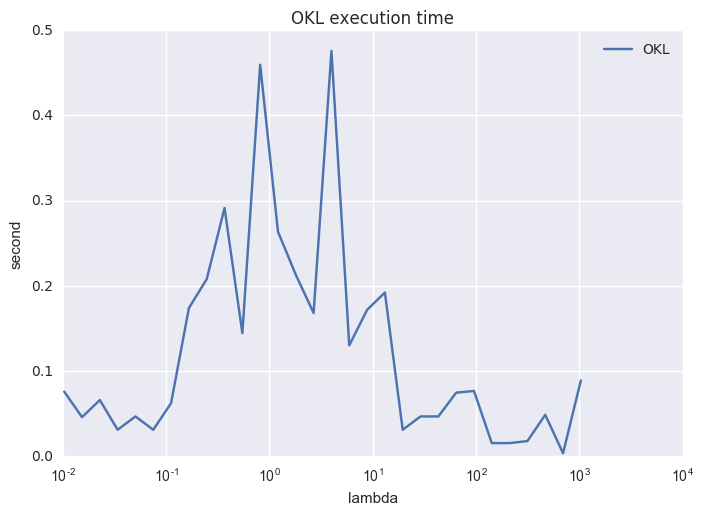

In [31]:
plt.semilogx(lam_list, ex_time,label='OKL')
plt.title('OKL execution time')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("second")
plt.legend(loc=0)

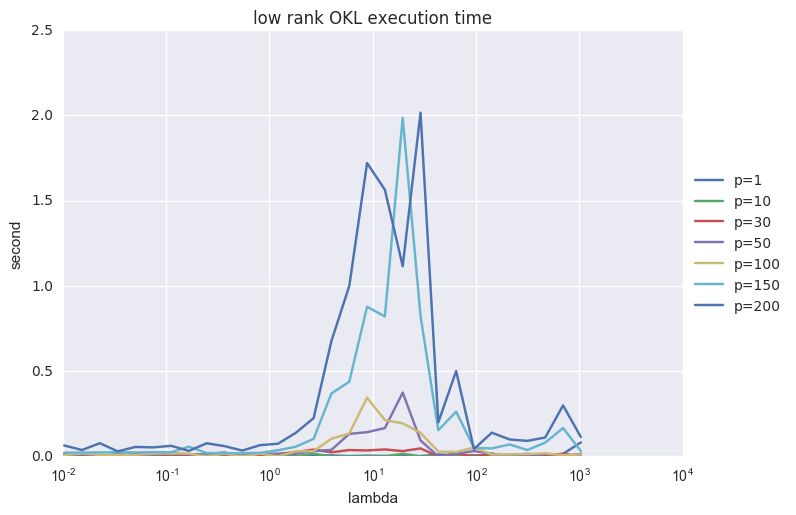

In [46]:
p_list_2=[1,10,30,50,100,150,200]
for i,p in enumerate(p_list_2):
    plt.semilogx(lam_list, LRex_time[p-1],label='p=%i'%p)
plt.title('low rank OKL execution time')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("second")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

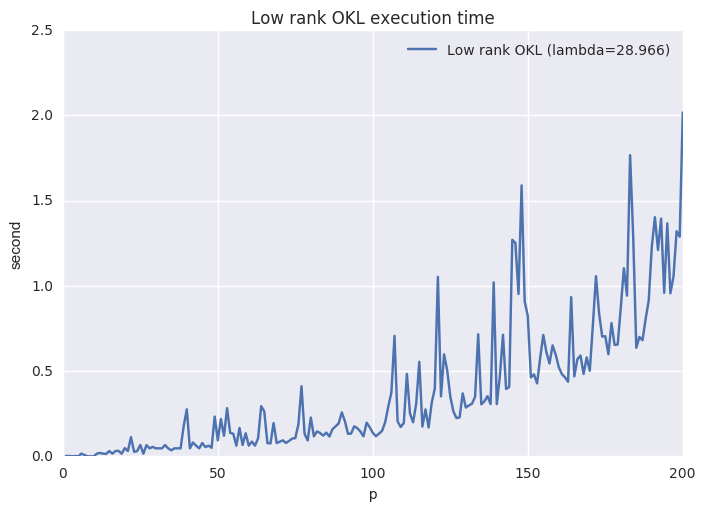

In [33]:
plt.plot(p_list, LRex_time[:,hh],label='Low rank OKL (lambda=%.3f)'%lam_list[hh])
plt.title('Low rank OKL execution time')
plt.grid(True)
plt.xlabel("p")
plt.ylabel("second")
plt.legend(loc=0)

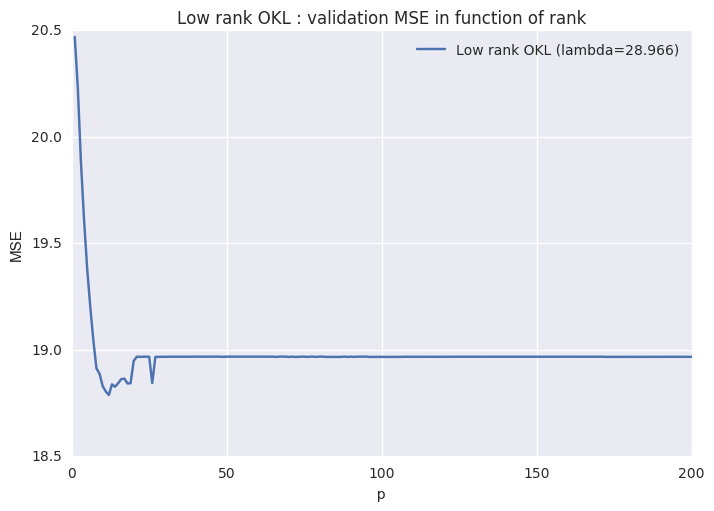

In [34]:
plt.plot(p_list, LROKLVMSE[:,hh],label='Low rank OKL (lambda=%.3f)'%lam_list[hh])
plt.title('Low rank OKL : validation MSE in function of rank')
plt.grid(True)
plt.xlabel("p")
plt.ylabel("MSE")
plt.legend(loc=0)

In [41]:
c=sns.color_palette()

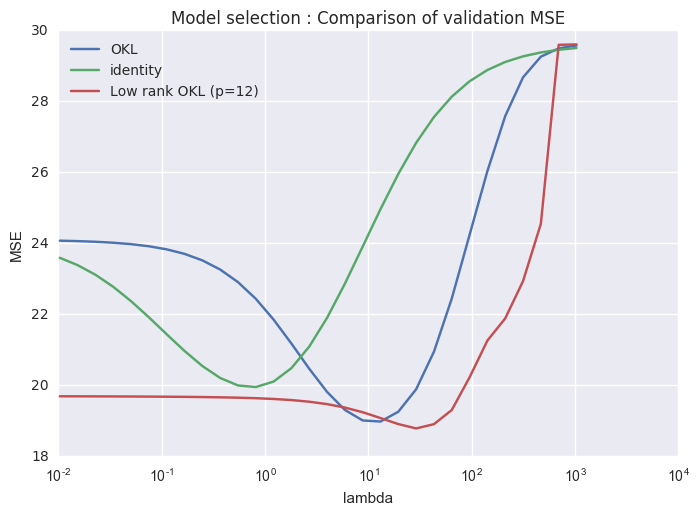

In [43]:
plt.semilogx(lam_list, OKLVMSE,label='OKL',color=c[0])
plt.semilogx(lam_list, IDVMSE,label='identity',color=c[1])
plt.semilogx(lam_list, LROKLVMSE[kk],label='Low rank OKL (p=%i)'%p_list[kk],color=c[2])
#plt.axvline(x=lam_list[jj],color='red',linestyle='--')
#plt.axvline(x=lam_list[ii],color='blue',linestyle='--')
#plt.axvline(x=lam_list[hh],color='green',linestyle='--')
plt.title('Model selection : Comparison of validation MSE')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc=0)


# Plot (test result)

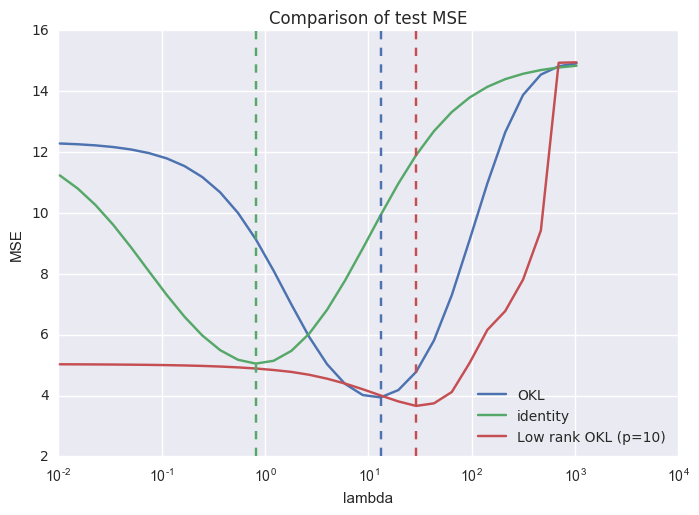

In [44]:
plt.semilogx(lam_list, OKLMSE,label='OKL',color=c[0])
plt.semilogx(lam_list, IDMSE,label='identity',color=c[1])
plt.semilogx(lam_list, LROKLMSE[kk],label='Low rank OKL (p=10)',color=c[2])
plt.axvline(x=lam_list[jj],color=c[0],linestyle='--')
plt.axvline(x=lam_list[ii],color=c[1],linestyle='--')
plt.axvline(x=lam_list[hh],color=c[2],linestyle='--')
plt.title('Comparison of test MSE')
plt.grid(True)
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc=0)


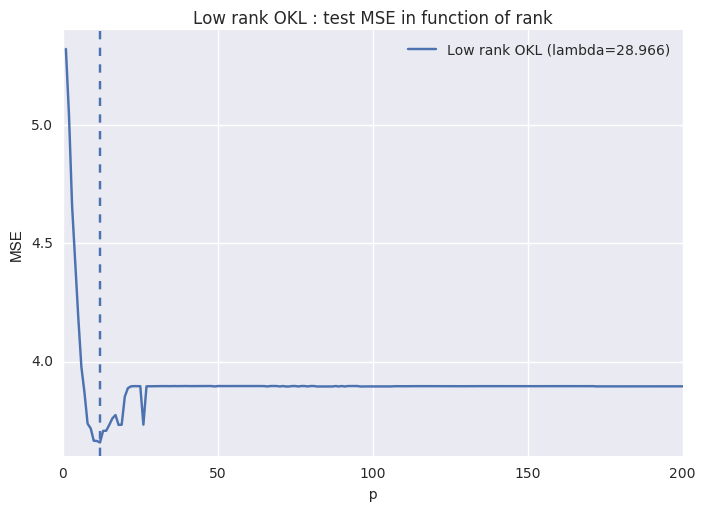

In [45]:
plt.plot(p_list, LROKLMSE[:,hh],label='Low rank OKL (lambda=%.3f)'%lam_list[hh],color=c[0])
plt.title('Low rank OKL : test MSE in function of rank')
plt.axvline(x=p_list[kk],color=c[0],linestyle='--')
plt.grid(True)
plt.xlabel("p")
plt.ylabel("MSE")
plt.legend(loc=0)